# Numerical resolution of BBM equation using a Finite Volume method

## Model : Benjamin-Bona-Mahony (BBM) equation :

We will compute an approximate solution to the BBM equation, which models a long-wave propagation accounting for nonlinear and dispersive effects (in an alternative formulation for the KdV equation, with better stability and numerical properties): 

\begin{equation}
\begin{cases}
    u_t + au_x + b(u^2)_x - cu_{xxt} = 0 \ , \ \ x \in [x_{min},x_{max}], \ \ t \in [0, t_{max}] \\
    u(x,0) = \Phi(x)
\end{cases}
\end{equation}

The BBM model will be treated here in the same way we did for the KdV equation : we will use an split method, leading to the resolution of the following problem in each time step: 

\begin{equation}
\begin{cases}
    v_t + av_x + b(v^2)_x = 0 \ \ ,\ t \in [t_n,t_{n+1}], \  v(t_n) = u(t_n) \\
    w_t - cw_{xxt} = 0 \ \ , \ t \in [t_n,t_{n+1}], \  w(t_n) = v(t_{n+1}) \\
    u(t_{n+1}) = v(t_{n+1})
\end{cases}
\end{equation}

The first equation (which is the same as in the KdV equation) will be solved with a Finite Volume method, with a 4th order Runge-Kutta discretization for the time derivative. On the other hand, the second equation will be solved with a Fourier spectral method.  

## First equation
$ v_t + f(v)_x = 0, \ \ f(v) = av + bv^2 $


### Temporal discretization

#### Euler
$v_i^{n+1} = v_i^n - \Delta t  \  f(v_i^n)_x$

#### 4th order Runge-Kutta
\begin{equation}
\begin{cases}
k_1 = - f(v_i^n)_x \\
k_2 = - f\left(v_i^n + k_1\frac{\Delta t }{2}\right)_x \\
k_3 = - f\left(v_i^n + k_2\frac{\Delta t }{2}\right)_x \\
k_4 = - f(v_i^n + k_3 \Delta t)_x \\
v_i^{n+1} = v_i^n + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{cases}
\end{equation}



### Spatial discretization
$ f(v_i^n)_x = \frac{f\left(v_{i+1/2}^n\right) - f\left(v_{i-1/2}^n\right)}{\Delta x}$


### Choice of the steps
In the non-conservative form, the equation is written as

$v_t +  (1+2v)v_x = 0$

which configures an advection problem with velocity $1+2v$

The space and time steps must verify the CFL condition : 

$(a+2bv)\frac{\Delta t}{\Delta x} \leq 1$

in order to avoid non-physical behaviours (e.g. mass increasing). Thereforem for each time step, we will chose, for small $\epsilon$

$\Delta t = \frac{\Delta x}{a+2b\max\limits_{x}|v|} - \epsilon$





### Evaluation of the solution on cell interfaces : resolution of the Riemann problem
In each interface between two cells of the discrete domain, the follozing Riemann problem will be solved :

\begin{equation}
\begin{cases}
v_t + f(v)_x = 0 \\
v(x,0) = v^- \ , \ x < 0 \\
v(x,0) = v^+ \ , \ x > 0
\end{cases}
\end{equation}

where the boundary is located at $x=0$ and $v^-$ and $v^+$ are the solutions in its two neighbour cells.

The flux function $f$ is uniformly convex, so the Riemann problem has a unique weak, admissible solution (REFERENCE) :

* If $v^- > v^+$  (shock) : 
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \   f(v^-) > f(v^+) \\
v^+ \ ,\ \ f(v^-) < f(v^+)
\end{cases}
\end{equation}

* If $v^+ > v^-$  (rarefaction wave) :
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \ f'(v^-) > 0 \\
\left(f'\right)^{-1}(0) \ ,\ \ f'(v^-) < 0 < f'(v^+) \\
v^+ \ ,\ \ f'(v^+) < 0 
\end{cases}
\end{equation}

## Second equation

The second equation of the BBM splitted model can be written as

$(w - cw_{xx})_t=0$

showing that $w - w_{xx}$ does not depend on time. Therefore, for each time step $[t_n,t_{n+1}] : $

$w - cw_{xx} = (w - cw_{xx})\rvert_{t=t_n} = (v - cv_{xx})\rvert_{t=t_{n+1}} = g(x)$

This equation will be solved using the Fourier method. Let $\hat{w}(k,t_n)$ and $\hat{g}(k)$ be the Fourier coefficients of $w(x,t_n)$ and $g(x)$ respectively.  The Fourier transform of the above equation gives

$(\hat{w})(k,t) = \frac{\hat{g}(k)}{1+ck^2}$

The right-hand side of the last equation does not depend on time. Therefore, the inverse Fourier transform using the coefficients $\hat{w}(k,t)$ gives $w(x,t_{n+1})$

## Model functions

In [1]:
%%writefile kdv.py

import numpy as np
def Flux(u,a,b):
    return a*u + b*u*u
def Fluxder(u,a,b):
    return a + 2.0*b*u
def Fluxderinv(u,a,b):
    return (u-1.*a)/(2.*b)
def Flux2(u,a,b,dx):
    nx = u.size-1
    ux = np.zeros(nx+1)
    uxxx = np.zeros(nx+1)
    ff = np.zeros(nx+1)
    
    ux[1:nx] = (u[2:nx+1] - u[0:nx-1])/(2.*dx)
    ux[0] =  (u[1] - u[nx-1])/(2.*dx)
    #ux[nx-1] =  (u[0] - u[nx-2])/(2.*dx)
    ux[nx] =  (u[1] - u[nx-1])/(2.*dx)
    
    ux2 = ux*ux
    
    uxxx[2:nx-1] = (-1./2.*u[0:nx-3] + u[1:nx-2] - u[3:nx] + 1./2.*u[4:nx+1])/(dx*dx*dx)
    uxxx[0] = (-1./2.*u[nx-2] + u[nx-1] - u[1] + 1./2.*u[2])/(dx*dx*dx)
    uxxx[1] = (-1./2.*u[nx-1] + u[0] - u[2] + 1./2.*u[3])/(dx*dx*dx)
    uxxx[nx-1] = (-1./2.*u[nx-3] + u[nx-2] - u[0] + 1./2.*u[1])/(dx*dx*dx)
    uxxx[nx] = (-1./2.*u[nx-2] + u[nx-1] - u[1] + 1./2.*u[2])/(dx*dx*dx)
    
    #uxxx = 0*uxxx
    
    ff[1:nx-1] = a*u[1:nx-1] + b*u[1:nx-1]*u[1:nx-1] + \
                 dx/32.*(ux2[2:nx] - ux2[0:nx-2]) + \
                 (dx*dx/24.)*uxxx[1:nx-1]*(1.+2.*u[1:nx-1])
    ff[0] = a*u[0] + b*u[0]*u[0] + \
            dx/32.*(ux2[1] - ux2[nx-1]) + \
            (dx*dx/24.)*uxxx[0]*(1.+2.*u[0])
    ff[nx-1] = a*u[nx-1] + b*u[nx-1]*u[nx-1] + \
               dx/32.*(ux2[0] - ux2[nx-2]) + \
               (dx*dx/24.)*uxxx[nx-1]*(1.+2.*u[nx-1])
    ff[nx] = a*u[nx] + b*u[nx]*u[nx] + \
             dx/32.*(ux2[1] - ux2[nx-1]) +  \
             (dx*dx/24.)*uxxx[nx]*(1.+2.*u[nx])
            
    #print(uxxx)
    
    return ff

Overwriting kdv.py


In [2]:
%%writefile kdv.py -a

def Riemann(u,x,t,a,b):
    uint = np.zeros_like(x)
    for  i in range(0,x.size-1):
        #incl = x[i]/t
        incl = 0
        um = u[i]
        up = u[i+1]
        if um == up :
            uint[i] = um
        elif  um > up:
            sigma = (Flux(um,a,b) - Flux(up,a,b))/(um-up)
            if incl < sigma:
                uint[i] = um
            else:
                uint[i] = up
        else:
            if incl < Fluxder(um,a,b) :
                uint[i] = um
            elif incl > Fluxder(up,a,b) :
                uint[i] = up
            else:
                uint[i] = Fluxderinv(incl,a,b)
    #uint[0] = u[0]
    uint[x.size-1] = u[x.size-1]
    return uint

Appending to kdv.py


In [3]:
%%writefile kdv.py -a

def Euler(u,dx,dt,periodic):
    umm = np.roll(u,1)
    if periodic :
        umm[0] = u[u.size-1]
    
    f = Flux(u)
    fmm = Flux(umm)
    
    u2 = u - dt/dx*(f-fmm)
    
    return u2

Appending to kdv.py


In [4]:
%%writefile kdv.py -a

def getRKCoef(u,x,t,dx,dt,a,b,periodic):
    uint = Riemann(u,x,t,a,b)
    uintmm = np.roll(uint,1)
    if periodic :
        uintmm[0] = uintmm[u.size-1]
    else :
        uintmm[0] = u[0]
        uint[u.size-1] = u[u.size-1]
        
    f = Flux(uint,a,b)
    fmm = Flux(uintmm,a,b)
    #print(uint[0],uintmm[0],uint[u.size-1],uintmm[u.size-1])
    return dt*(fmm-f)/dx
        
def RK4(u,x,t,dx,dt,a,b,periodic):
        
    k1 = getRKCoef(u,x,t,dx,dt,a,b,periodic)
    k2 = getRKCoef(u+k1/2,x,t,dx,dt,a,b,periodic)
    k3 = getRKCoef(u+k2/2,x,t,dx,dt,a,b,periodic)
    k4 = getRKCoef(u+k3,x,t,dx,dt,a,b,periodic)
    
    u2 = u + 1./6.*(k1+2*k2+2*k3+k4)
    
    return u2

Appending to kdv.py


In [5]:
%%writefile kdv.py -a

def FourierSolverBBM(u,t,dt,dx):
    k = 1./(dx*dx)
    
    nx = u.size-1
    
    uxx = np.zeros(nx+1)
    #uxx[1:nx] = 1./(dx*dx) * (u[0:nx-1] -2.*u[1:nx] + u[2:nx+1])
    #uxx[0] = 1./(dx*dx)*(u[nx-1] -2.*u[0] + u[1])
    #uxx[nx] = uxx[0]
    
    for i in range(1,nx-1):
        uxx[i] = k *(u[i-1] -2.*u[i] + u[i+1])
    uxx[0] = k *(u[nx-1] -2.*u[0] + u[1])
    uxx[nx-1] = k *(u[nx-2] -2.*u[nx-1] + u[0])
    uxx[nx] = uxx[0]
    #uxx[0] = uxx[nx-1]
    #uxx[nx] = uxx[1]
    
    #uxx[2:nx-1] = 1./(dx*dx) * (-1./12.*u[0:nx-3] + 4./3.*u[1:nx-2] -5./2.*u[2:nx-1] + 4./3.*u[3:nx] -1./12.*u[4:nx+1] )
    #uxx[0] = 1./(dx*dx) * (-1./12.*u[nx-2] + 4./3.*u[nx-1] -5./2.*u[0] + 4./3.*u[1] -1./12.*u[2] )
    #uxx[1] = 1./(dx*dx) * (-1./12.*u[nx-1] + 4./3.*u[0] -5./2.*u[1] + 4./3.*u[2] -1./12.*u[3] )
    #uxx[nx-1] = 1./(dx*dx) * (-1./12.*u[nx-3] + 4./3.*u[nx-2] -5./2.*u[nx-1] + 4./3.*u[0] -1./12.*u[1] )
    #uxx[nx] = uxx[0]
    
    g = u - uxx
    
    ghat = np.fft.fft(g)
    freq = np.fft.fftfreq(ghat.size,d=dx)
    #freq = np.linspace(-nx/2,nx/2,nx+1)
    #freq = np.fft.fftshift(freq)
    k = np.fft.ifft(1./(1.+freq*freq))
    uhat = ghat/(1.+freq*freq)
    u3 = np.fft.ifft(uhat)
    u2 = np.convolve(g,k,mode='same')

    return np.real(u3)

Appending to kdv.py


In [6]:
%%writefile kdv.py -a

def FourierSolverBBM2(u,uxx,t,dt,dx):
    k = 1./(dx*dx)
    
    nx = u.size-1
       
    g = u - uxx
    
    ghat = np.fft.fft(g)
    freq = np.fft.fftfreq(ghat.size,d=dx)
    #freq = np.linspace(-nx/2,nx/2,nx+1)
    #freq = np.fft.fftshift(freq)
    k = np.fft.ifft(1./(1.+freq*freq))
    uhat = ghat/(1.+freq*freq)
    u3 = np.fft.ifft(uhat)
    u2 = np.convolve(g,k,mode='same')

    return np.real(u3)

Appending to kdv.py


In [7]:
%%writefile kdv.py -a

import sys
import math


def FDSolverBBM(u,t,dt,dx,BC):
    k = 1./(dx*dx)

    nx = u.size - 1

    d0 = 1.+2.*k*np.ones(nx+1)
    d1 = -k*np.ones(nx)
    
    M = np.diag(d0) + np.diag(d1,1) + np.diag(d1,-1)
          
    vvv = np.zeros(nx+1)
    vvv[0] = 1. - 1.*k
    vvv[1] = 2.*k
    vvv[2] = -1.*k  
    
    zzz = np.flipud(vvv)

    M[0,:] = vvv   
    M[nx,:] = zzz

    uxx = np.zeros(nx+1)
    uxx[1:nx] = k*(u[0:nx-1] -2.*u[1:nx] + u[2:nx+1])
    uxx[0] = uxx[1]
    uxx[nx] = uxx[nx-1]
    
    rhs = u - uxx
    
    ### Boundary conditions
    ## Structure : BC=[u(left),ux(left),uxx(left),alpha*u(left) + beta*ux(right),
    ##                 u(right),ux(right),uxx(right),alpha*u(right) + beta*ux(right),
    ##                 alpha,beta] 
    cntBC = 0
    if not math.isnan(BC[0]) : # u L
        cntBC = cntBC+1
        M[0,:] = 0.
        M[0,0] = 1.
        rhs[0] = BC[0]
    if not math.isnan(BC[1]) : # ux L
        cntBC = cntBC+1
        M[1,:] = 0.
        M[1,0] = -1.
        M[1,1] = 1.
        rhs[1] = dx*BC[1]
    if not math.isnan(BC[2]) : # uxx L
        cntBC = cntBC+1
        M[2,:] = 0.
        M[2,0] = 1.
        M[2,1] = -2.
        M[2,2] = 1.
        rhs[2] = dx*dx*BC[2]
    if not math.isnan(BC[3]) : # Robin L
        cntBC = cntBC+1
        if not (math.isnan(BC[0]) and math.isnan(BC[1])) :
            sys.exit("Error in left BC : Robin defined with Dirichlet and/or Neumann")
        M[0,:] = 0.
        M[0,0] = BC[8] - BC[9]/dx
        M[0,1] = BC[9]/dx   
        rhs[0] = BC[3]
    if not math.isnan(BC[4]) : # u R
        cntBC = cntBC+1
        M[nx,:] = 0.
        M[nx,nx] = 1.
        rhs[nx] = BC[4]
    if not math.isnan(BC[5]) : # ux R
        cntBC = cntBC+1
        M[nx-1,:] = 0.
        M[nx-1,nx] = 1.
        M[nx-1,nx-1] = -1.
        rhs[nx-1] = dx*BC[5]
    if not math.isnan(BC[6]) : # uxx R
        cntBC = cntBC+1
        M[nx-2,:] = 0.
        M[nx-2,nx] = 1.
        M[nx-2,nx-1] = -2.   
        M[nx-2,nx-2] = 1.
        rhs[nx-2] = dx*dx*BC[6]
    if not math.isnan(BC[7]) : # Robin R
        cntBC = cntBC+1
        if not (math.isnan(BC[4]) and math.isnan(BC[5])) :
            sys.exit("Error in right BC : Robin defined with Dirichlet and/or Neumann")
        M[nx,:] = 0.
        M[nx,nx] = BC[8] + BC[9]/dx
        M[nx,nx-1] = -BC[9]/dx   
        rhs[nx] = BC[7]
    
    if cntBC != 3 :
        print(cntBC)
        print(BC)
        sys.exit("Wrong number of BC")
        
    
    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)
    
    u2 = np.linalg.solve(M,rhs)

    #print(M)
    #print(u2)
    
    return u2

Appending to kdv.py


In [8]:
%%writefile kdv.py -a

def getDxx(u,uprev,dx,dt,a,b):
    
    nx = u.size-1
    
    ut = (u-uprev)/dt
    
    utx = np.zeros(nx+1)
    ux = np.zeros(nx+1)
    
    utx[1:nx] = (ut[2:nx+1] - ut[0:nx-1])/(2.*dx)
    utx[0] = (ut[1] - ut[nx-1])/(2.*dx)
    utx[nx] = utx[0]
    
    ux[1:nx] = (u[2:nx+1] - u[0:nx-1])/(2.*dx)
    ux[0] = (u[1] - u[nx-1])/(2.*dx)
    ux[nx] = ux[0]
    
    uxx = (-utx -2*b*ux*ux)/(a+2.*b*u)
    
    return uxx

Appending to kdv.py


In [9]:
%%writefile kdv.py -a

def discretizeSpace(xmin,xmax,dx) :
    nx = int((xmax-xmin)/dx)
    x = np.linspace(xmin, xmax,nx+1)
    x = np.arange(xmin, xmax,dx)    
    return x

Appending to kdv.py


In [10]:
%%writefile kdv.py -a

def runRk4FVFourierBBM(x,u,t0,tmax,a,b,periodic=1, bc=None, constantBC = True, vardt = True):
    t = t0
    tall = np.ones(1)*t0
    u0 = u
    uall = u
    u0min = np.amin(u)
    u0max = np.amax(u)
    dx = np.diff(x)[0]
    iter = 0
    eps = 1e-6

    ##### Parameters
    printstep = 5
    
    if not vardt :
        umax = np.amax(np.absolute(u))
        dt = dx/(1.*a+2*b*umax) - eps
    
    while t<tmax:
        iter = iter + 1
        
        if vardt:
            umax = np.amax(np.absolute(u))
            dt = dx/(1.*a+2*b*umax) - eps     # CFL CONDITION

        t = t+dt
        u = RK4(u,x,t,dx,dt,a,b,periodic)
        
        if periodic :
            u = FourierSolverBBM(u,t,dt,dx)
        else :
            if constantBC :
                BC = bc
            else :
                BC = bc[iter-1,:]
            u = FDSolverBBM(u,t,dt,dx,BC)
            ###u = ChebyshevSolver(x,u,dt,dx,A,B,C,cl)

        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
        if iter%100 == 0:
            print(iter,t)
    return uall,tall

Appending to kdv.py


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import kdv

%matplotlib inline

nan = float('nan')

In [12]:
### Wave 3
eps = 0.001
B = 0.1
A = .0001
wvl = .1
h0min = 1.5*A/eps
h0max = B*wvl/(2.*np.pi)
h0 = 0.5*(h0min+h0max)
alpha2 = h0*h0/6.

L = wvl
xmin = -L
xmax = L
N = 100
dx = (xmax-xmin)/N
x = kdv.discretizeSpace(xmin,xmax,dx)

print(r'*** Wave 3 ***')
print(r'Amplitude : %f' %A)
print(r'Wavelength : %f' %wvl)
print(r'1/(2.*Wavelength^2) : %f' %(1./(2.*wvl*wvl)))
print(r'h0min : %f' %h0min)
print(r'h0max : %f' %h0max)
print(r'eps : %f' %eps)
print(r'B : %f' %B)
print(r'alpha^2 : %f' %alpha2)
print(r'Space steps : %d' %x.size)

*** Wave 3 ***
Amplitude : 0.000100
Wavelength : 0.100000
1/(2.*Wavelength^2) : 50.000000
h0min : 0.150000
h0max : 0.001592
eps : 0.001000
B : 0.100000
alpha^2 : 0.000957
Space steps : 100


In [15]:
u = np.zeros_like(x)
u = A*np.exp(-(x-0.)**2/(2.*wvl*wvl))
#u = np.where( (x>=3.*wvl)*(x<=4.*wvl), 1.0, u)
T = 100
umax = np.amax(np.absolute(u))
dt = dx/(1.+2*umax) - eps
i = 0
iters=np.array([0])

while i*dt < T :
    i = i+1
    iters = np.append(iters,i*dt)

source = A*np.cos(np.pi*iters)
vz = np.zeros_like(source)
vnan = np.ones_like(source)*nan

#BC=np.array([source,vz,vnan,vnan,vz,vnan,vnan,vnan,vz,vz]).transpose()
BC=np.array([0,0,nan,nan,0,nan,nan,nan,0,0]).transpose()


uall, tall = kdv.runRk4FVFourierBBM(x,u,t0=0,tmax=.3,a=1,b=1,periodic=0,bc=BC, constantBC=True, vardt = True)

(100, 0.199894098485737)



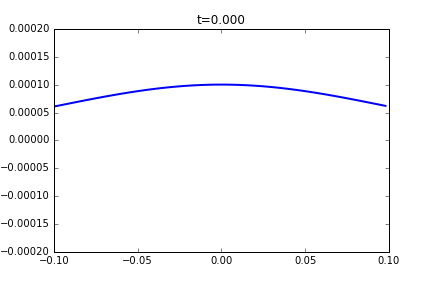
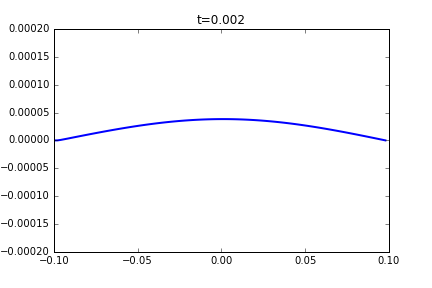
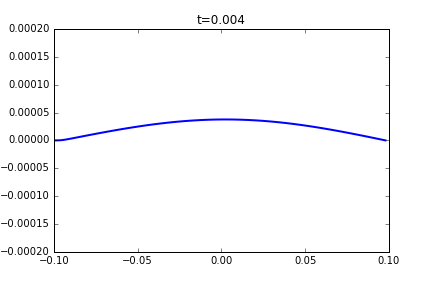
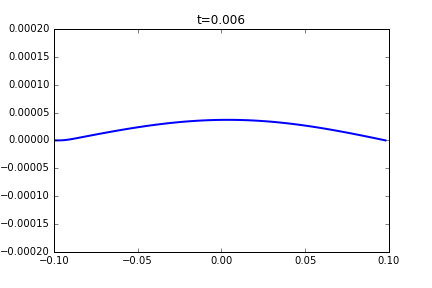
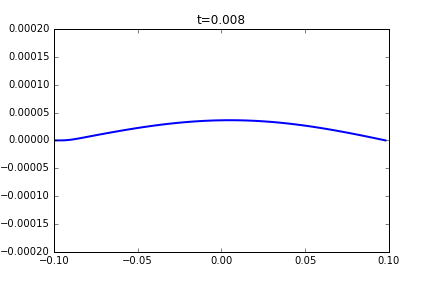
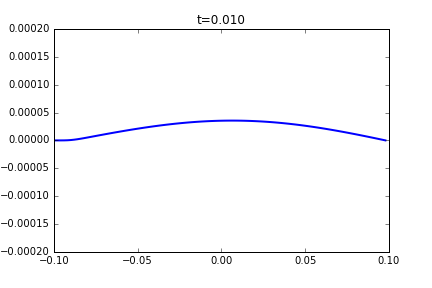
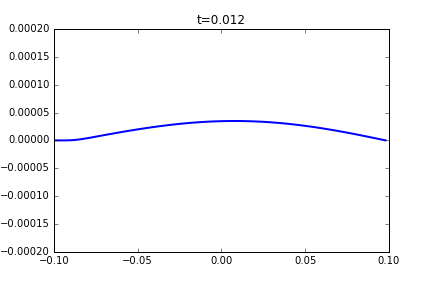
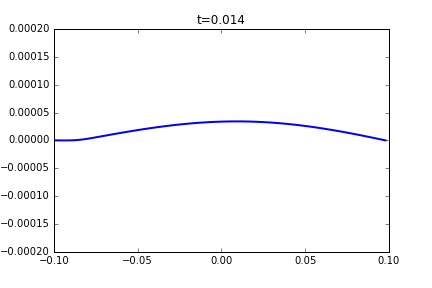
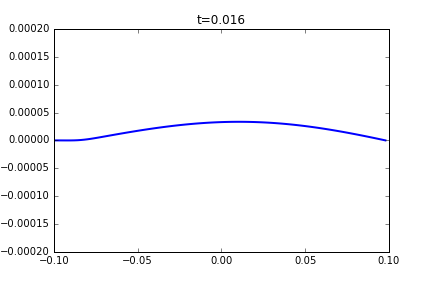
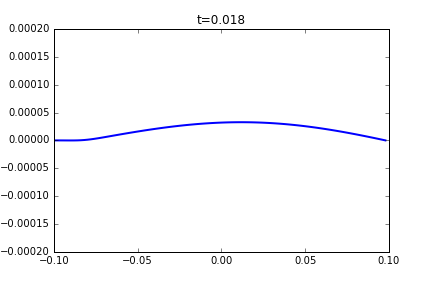
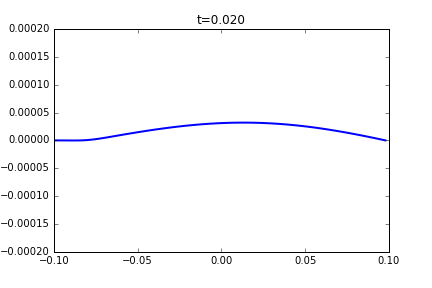
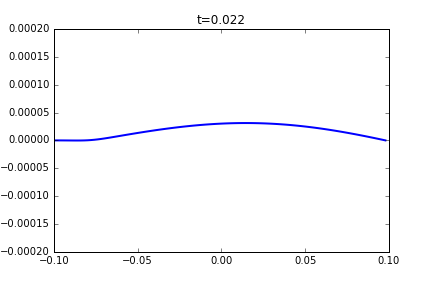
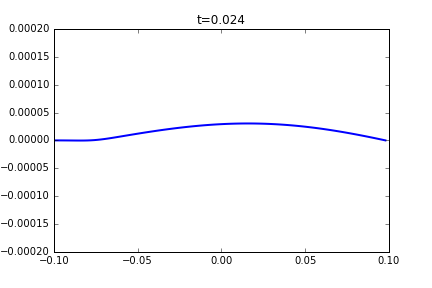
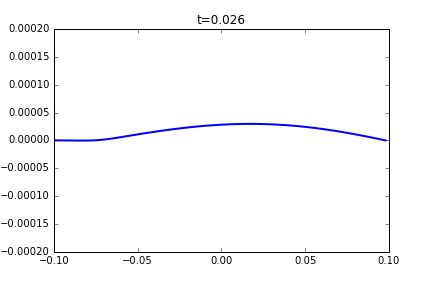
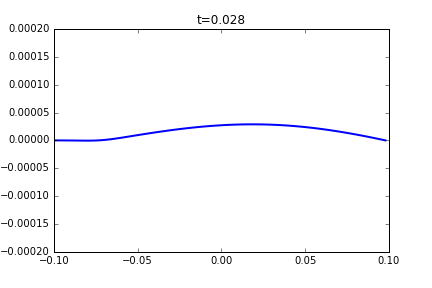
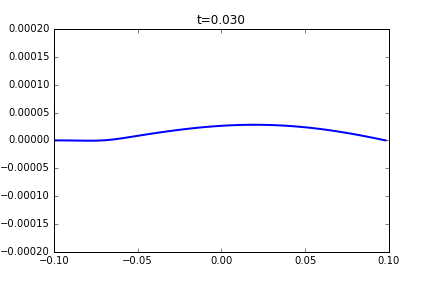
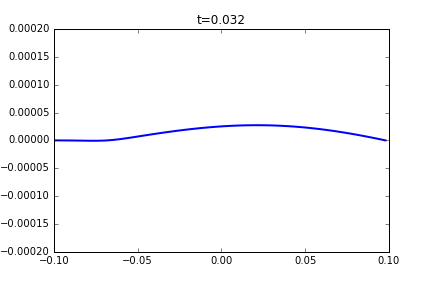
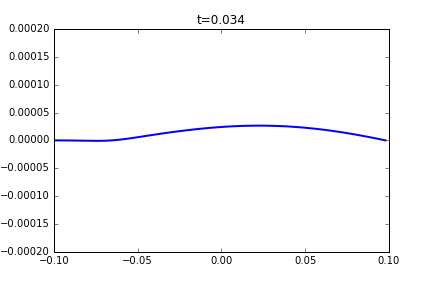
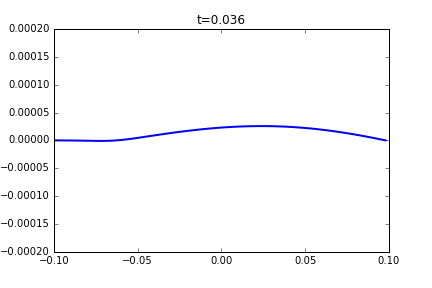
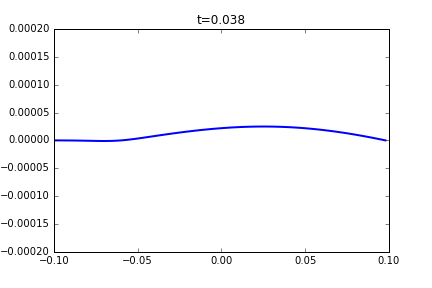
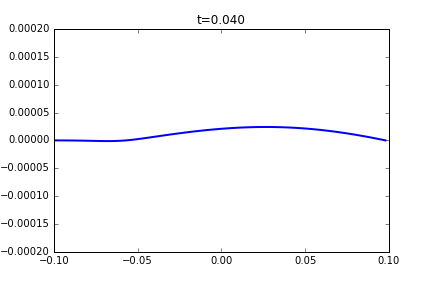
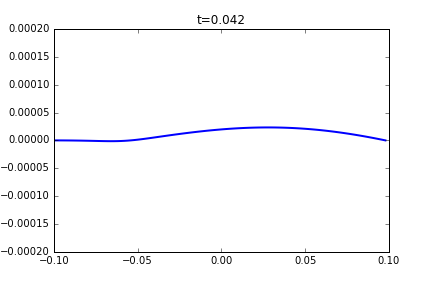
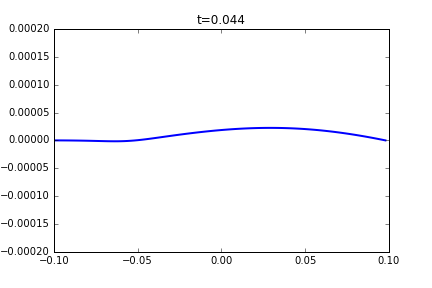
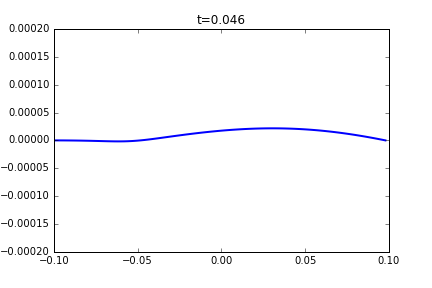
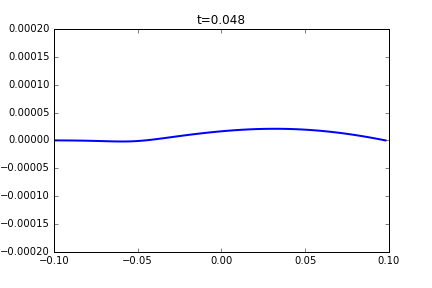
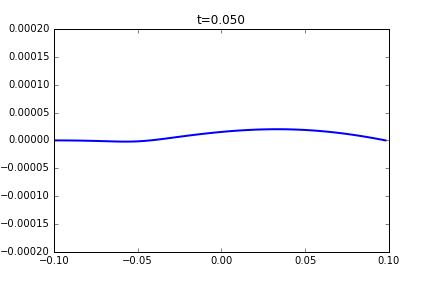
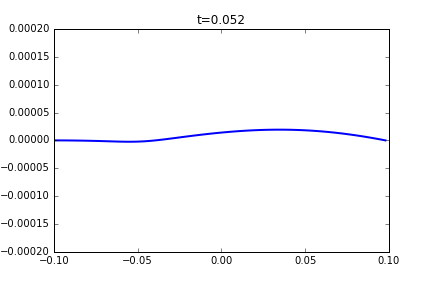
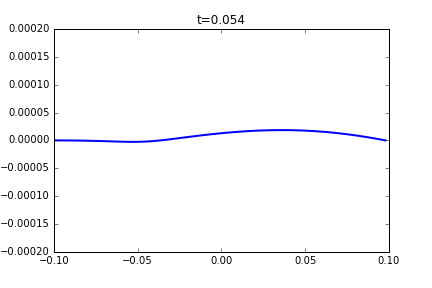
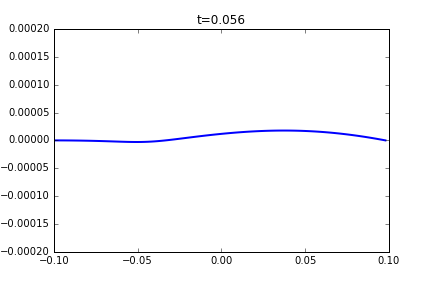
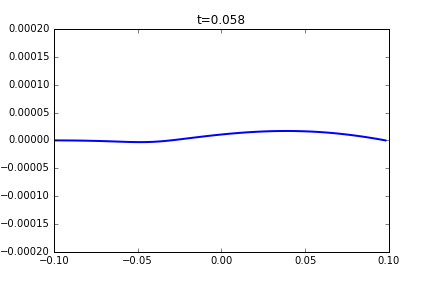
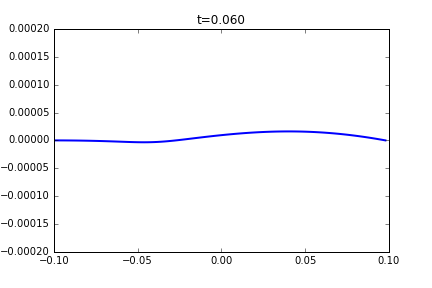
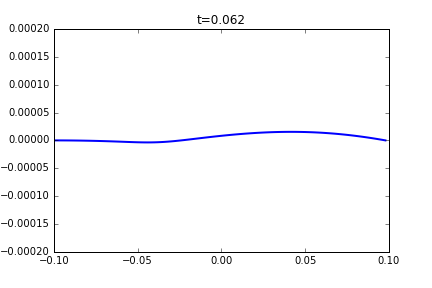
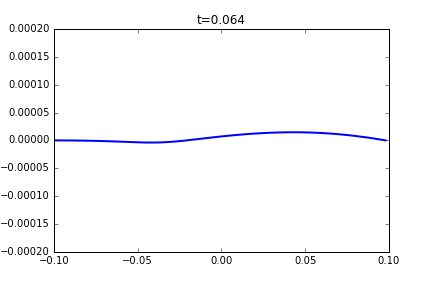
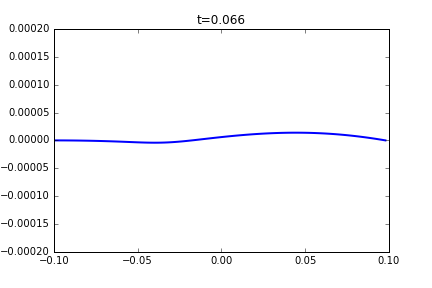
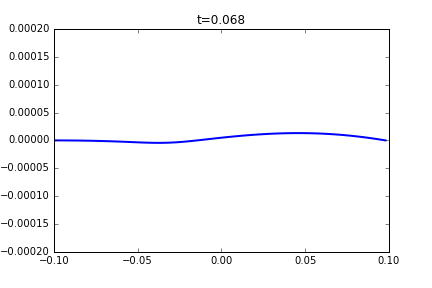
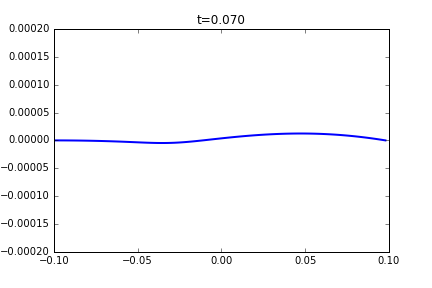
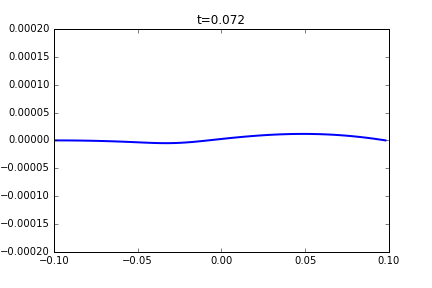
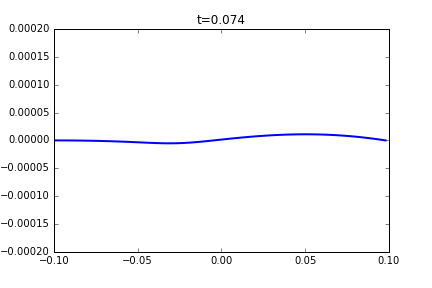
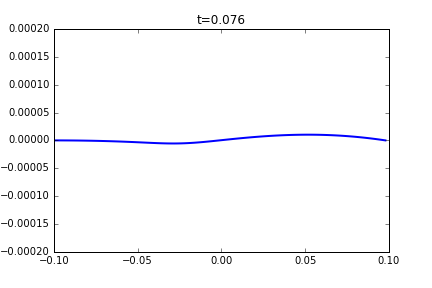
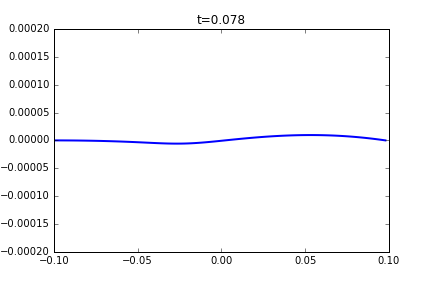
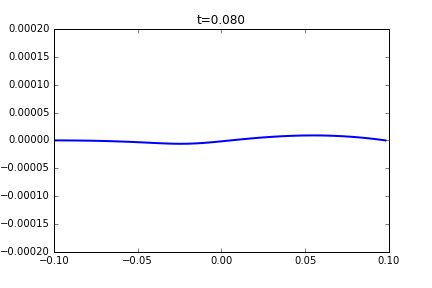
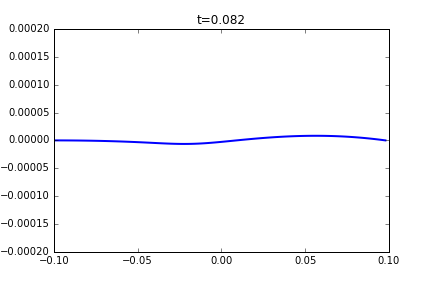
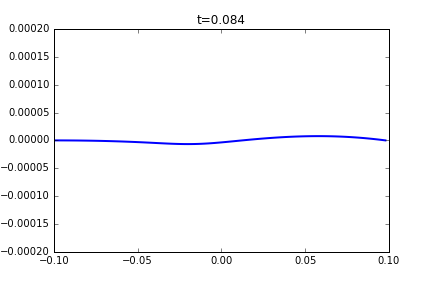
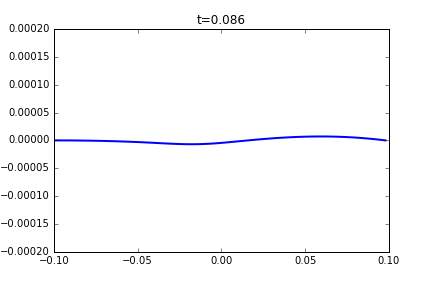
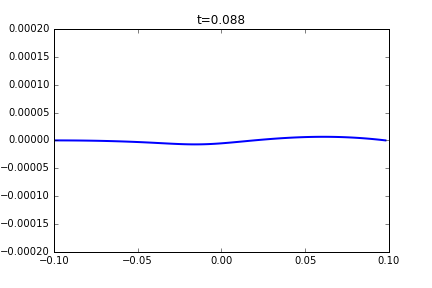
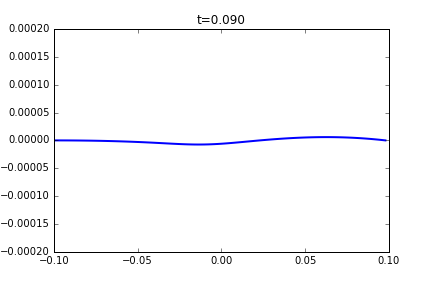
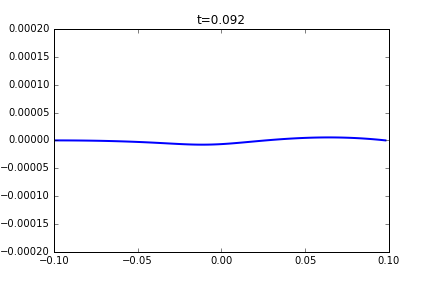
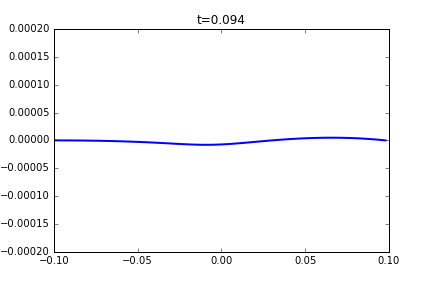
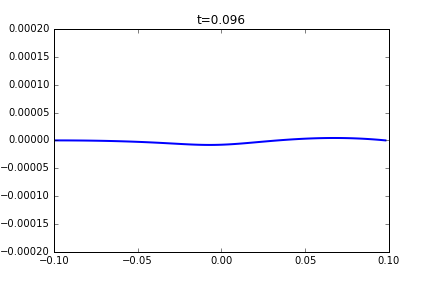
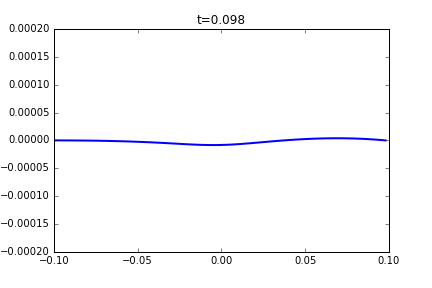
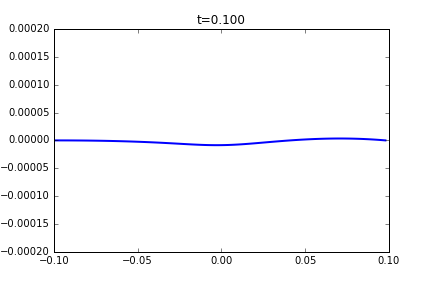
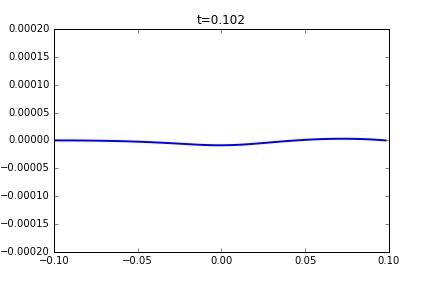
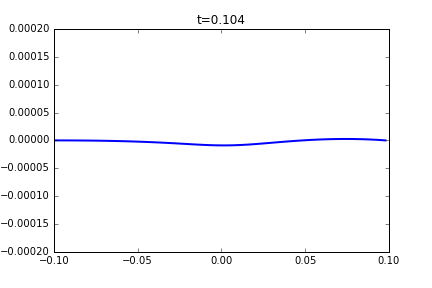
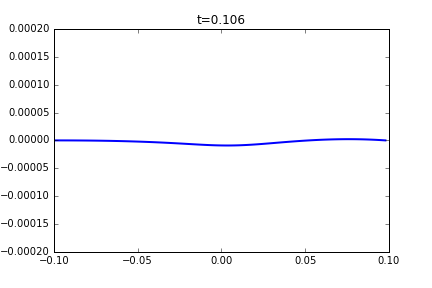
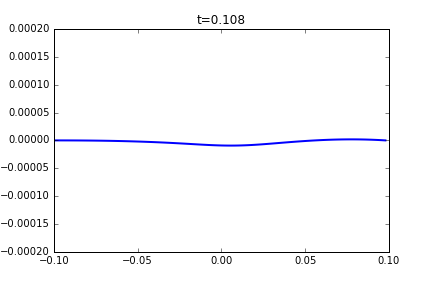
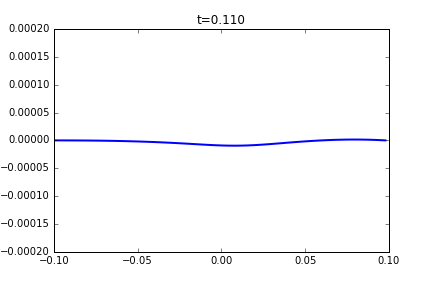
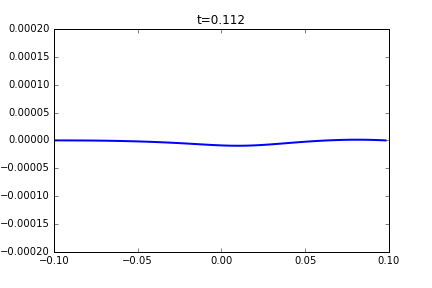
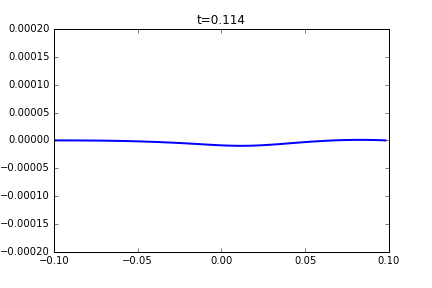
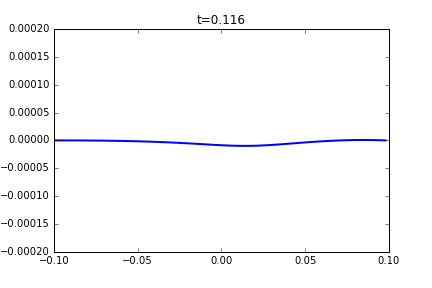
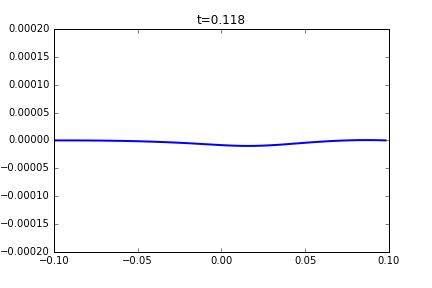
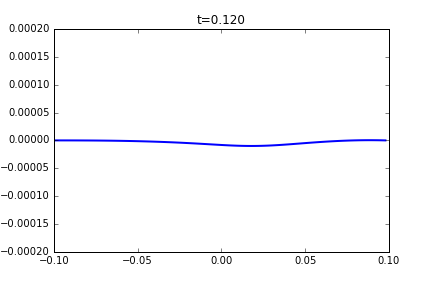
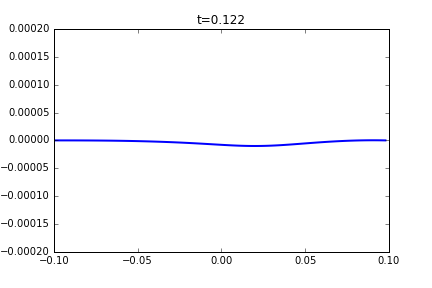
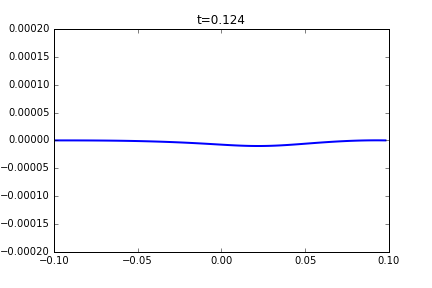
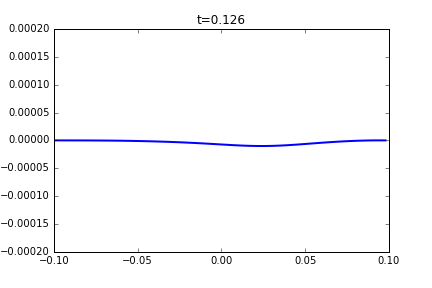
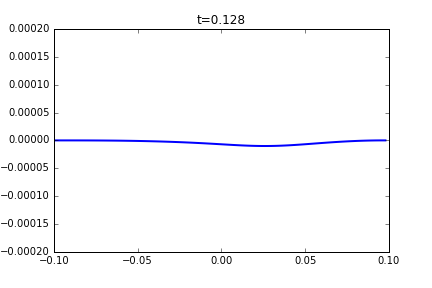
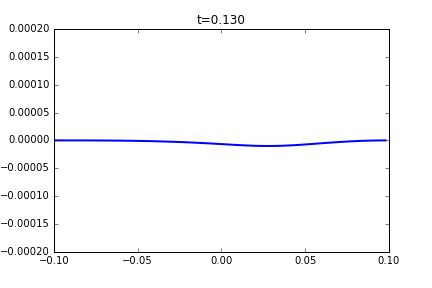
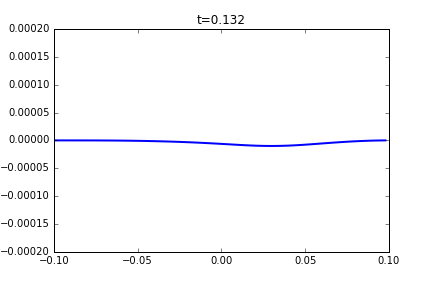
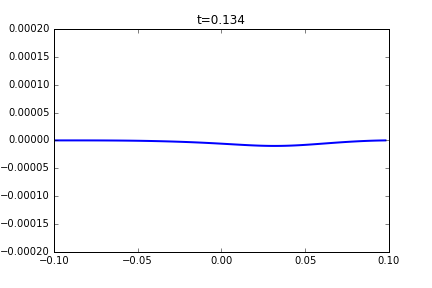
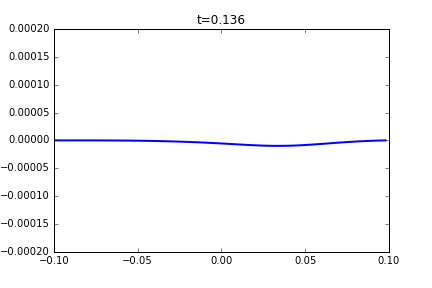
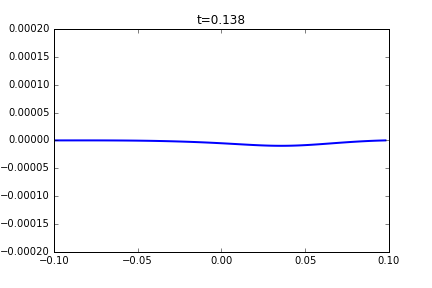
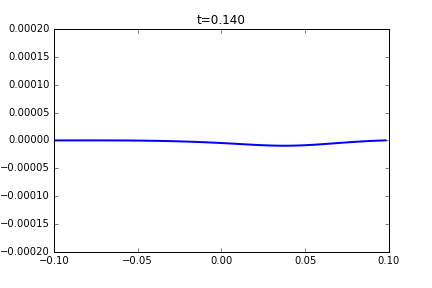
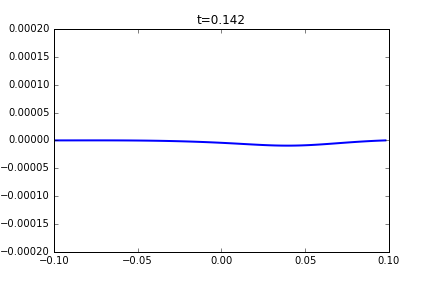
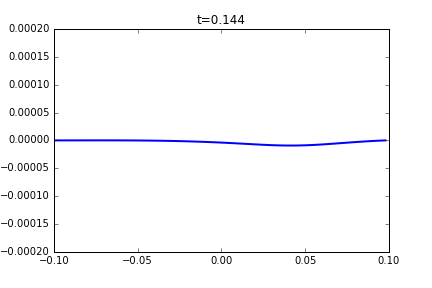
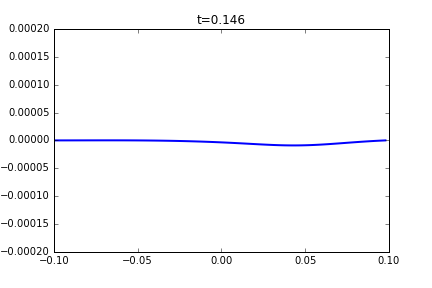
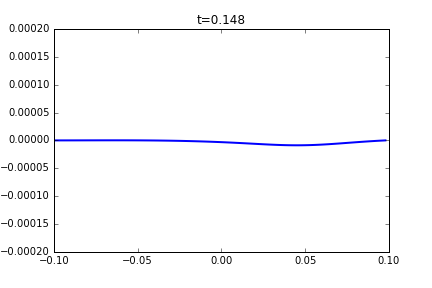
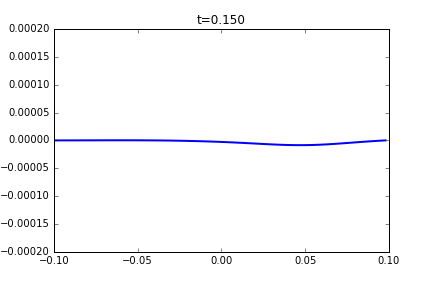
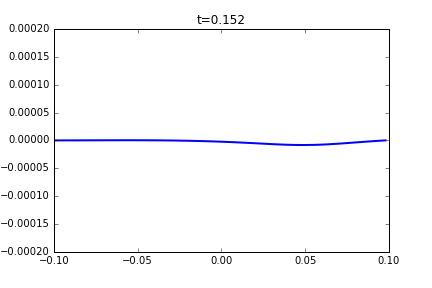
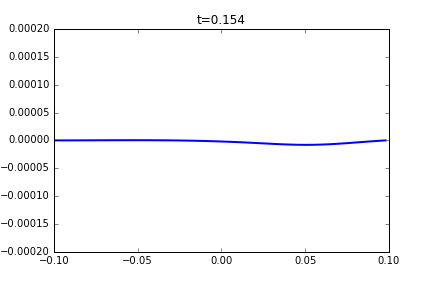
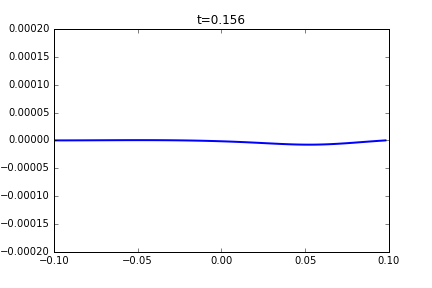
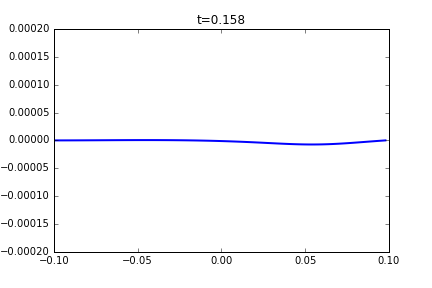
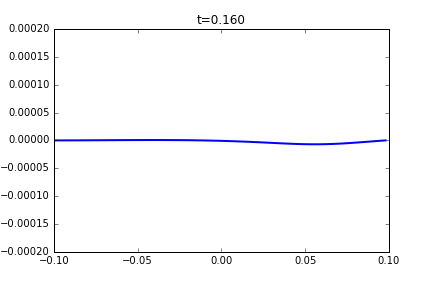
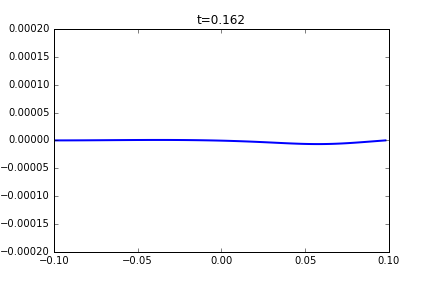
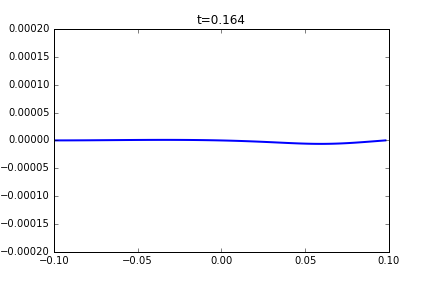
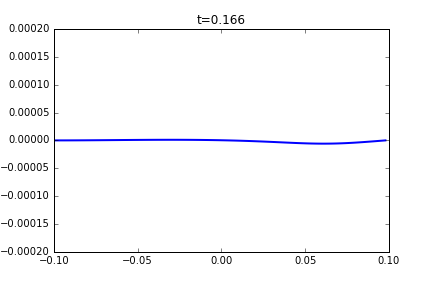
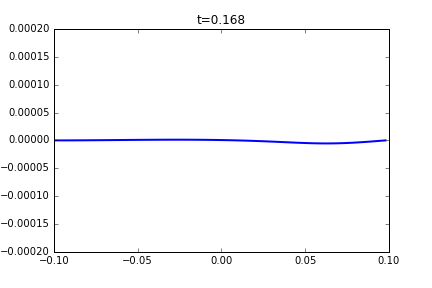
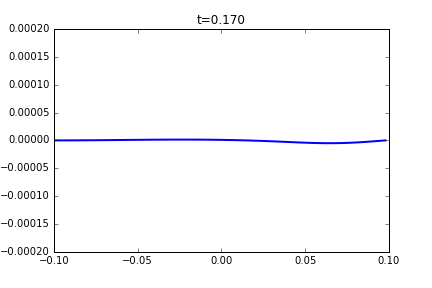
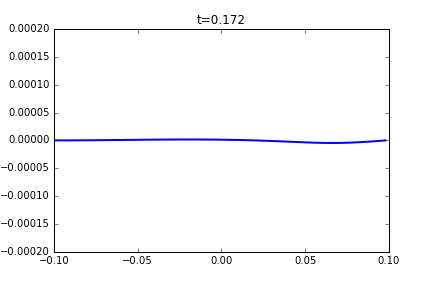
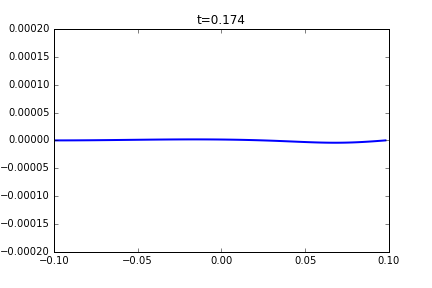
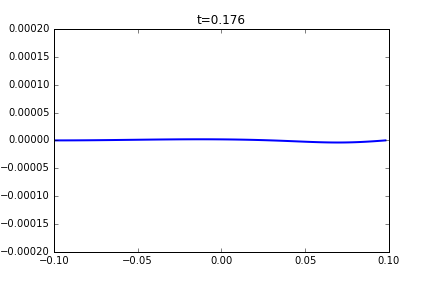
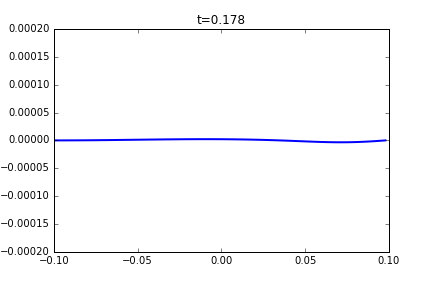
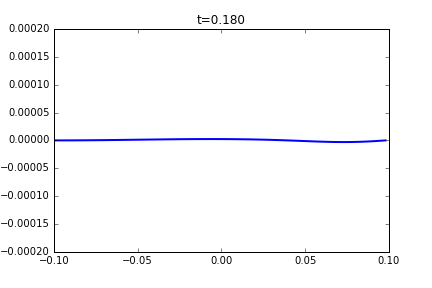
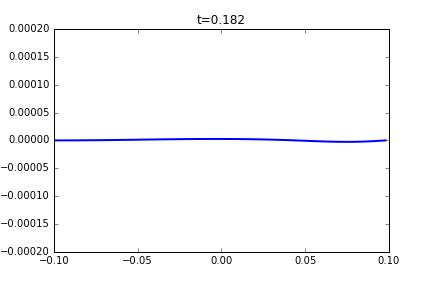
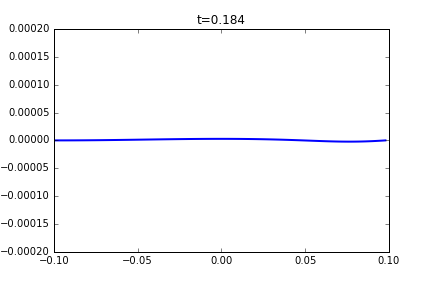
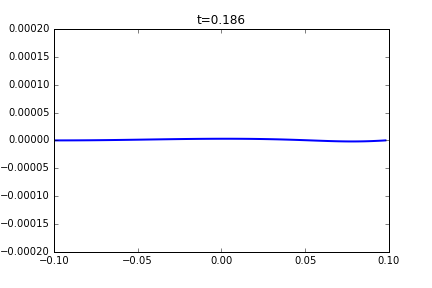
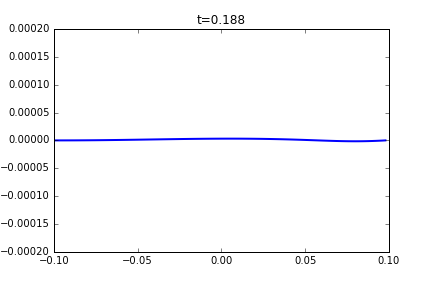
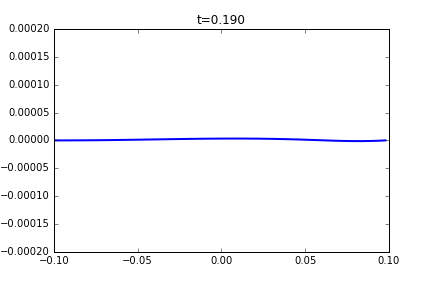
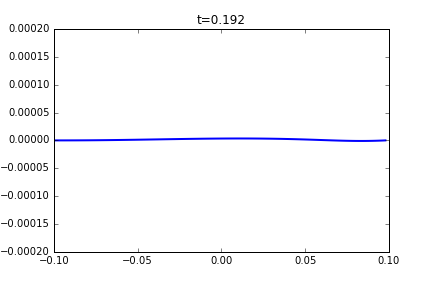
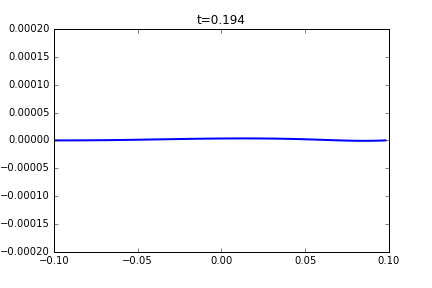
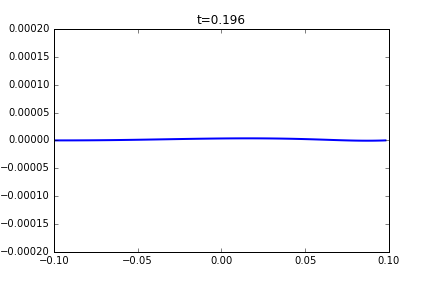
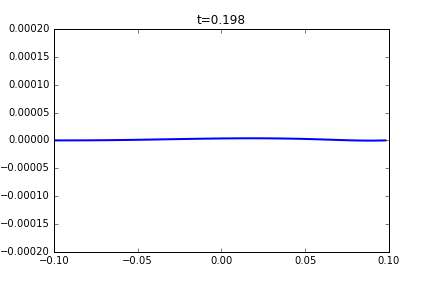
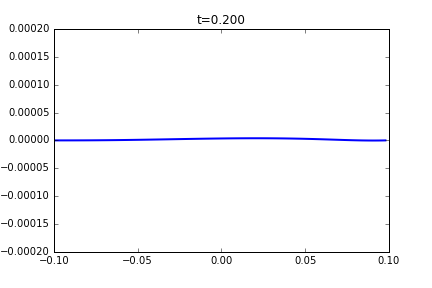
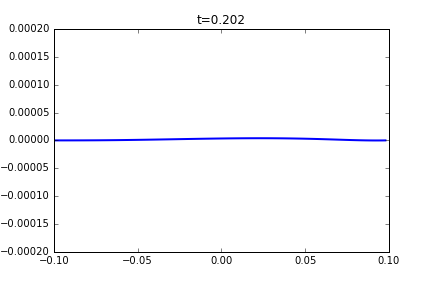
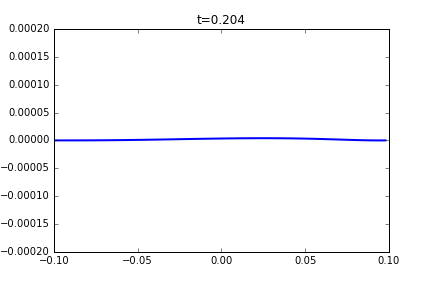
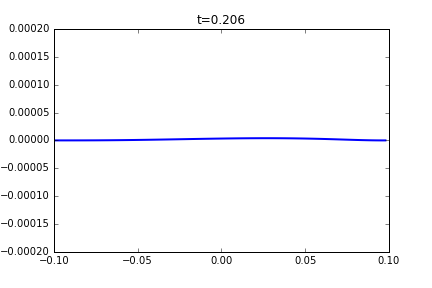
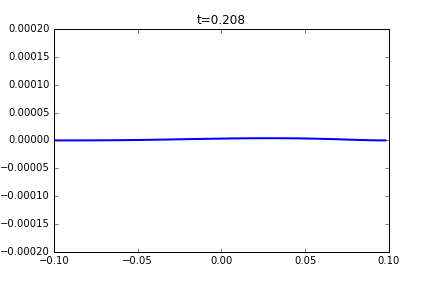
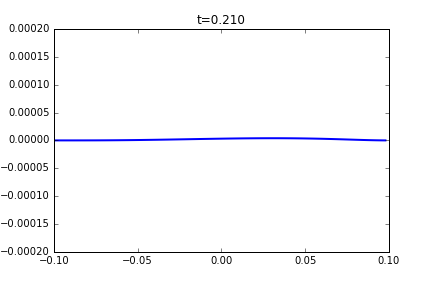
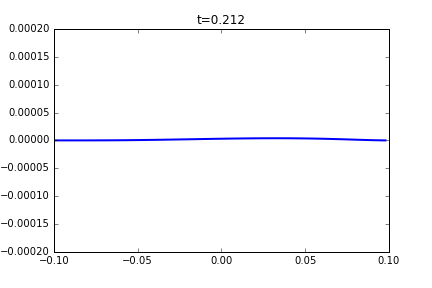
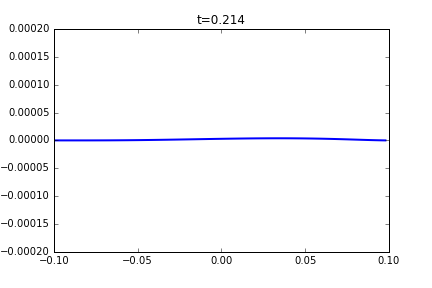
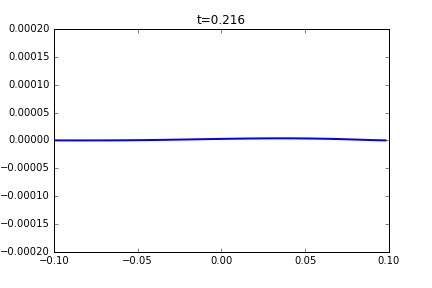
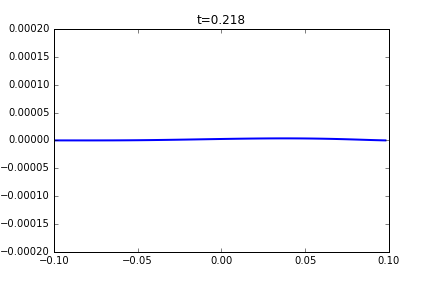
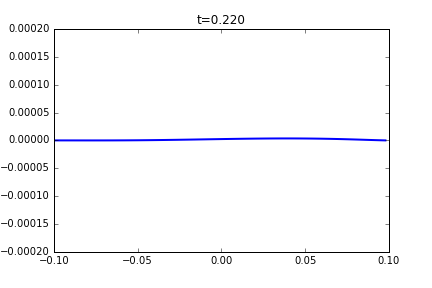
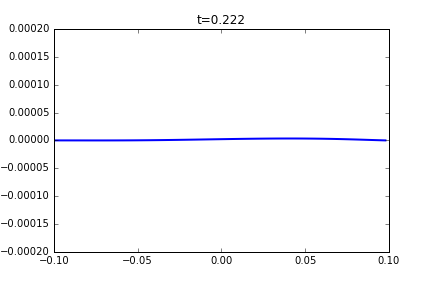
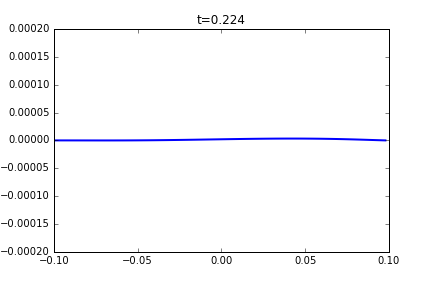
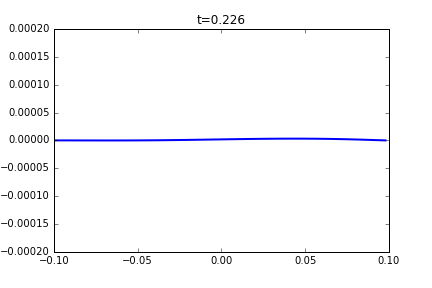
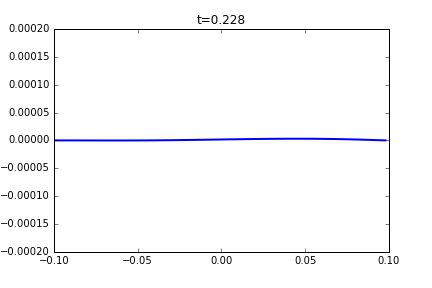
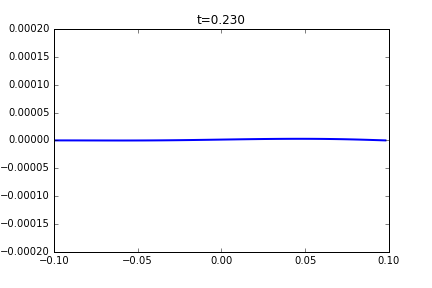
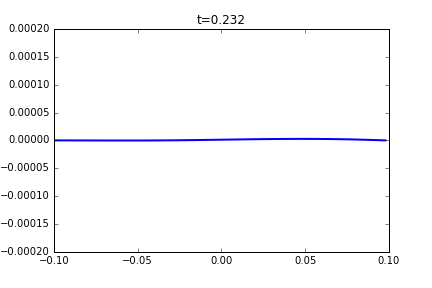
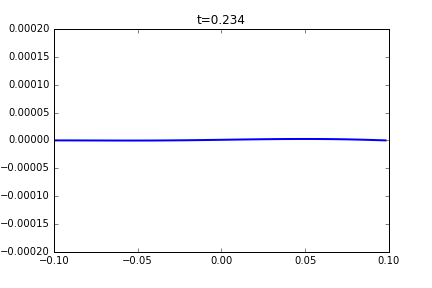
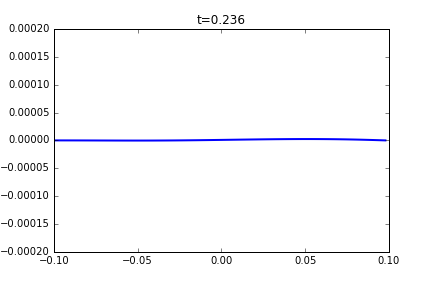
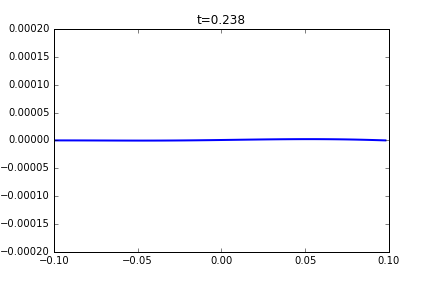
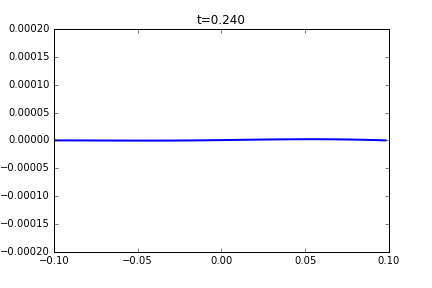
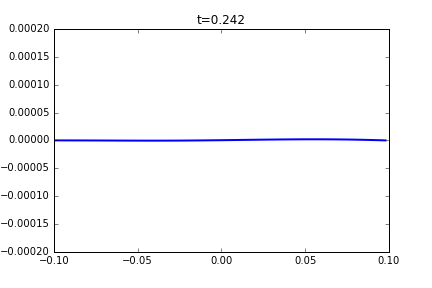
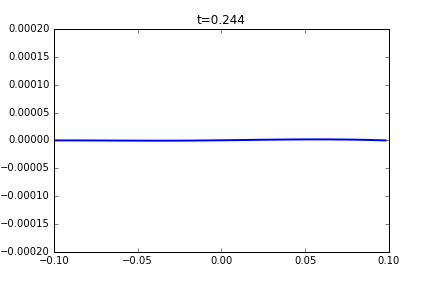
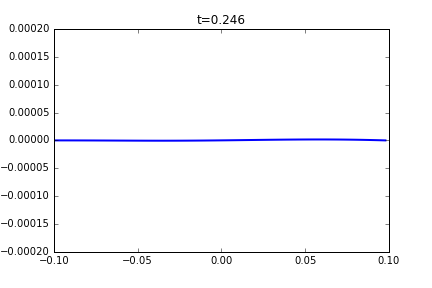
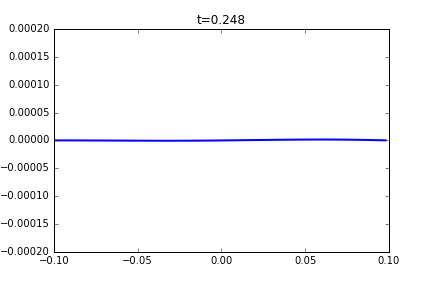
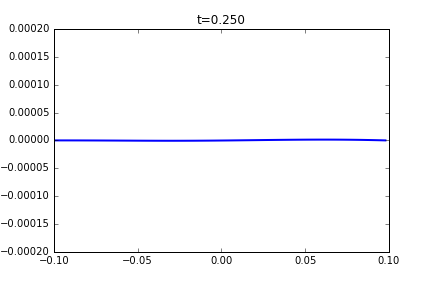
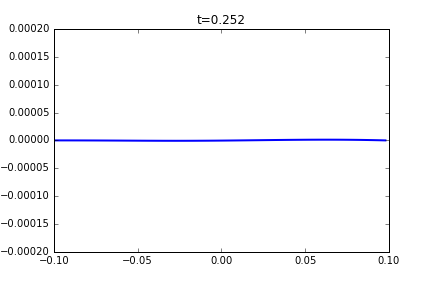
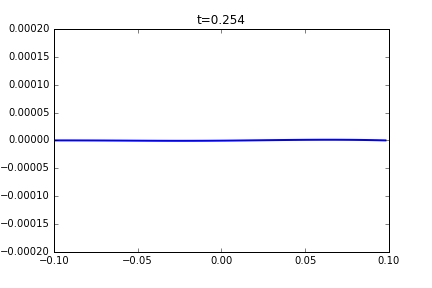
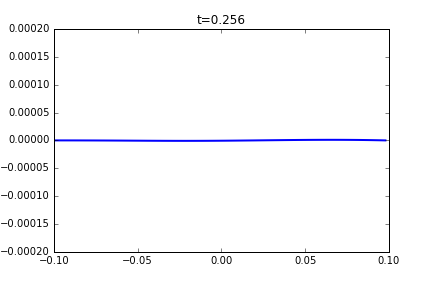
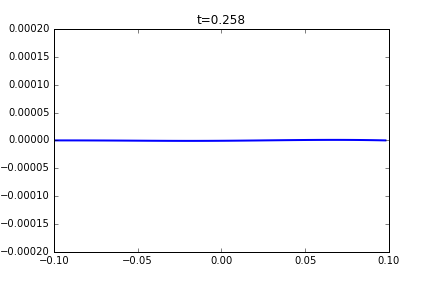
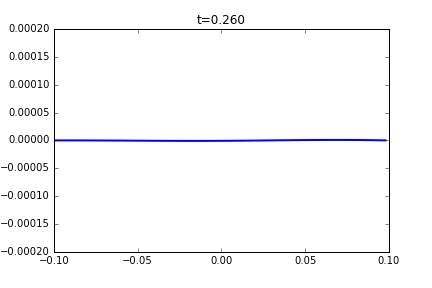
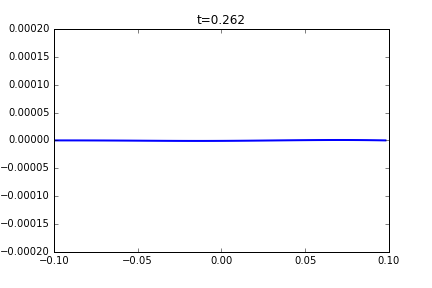
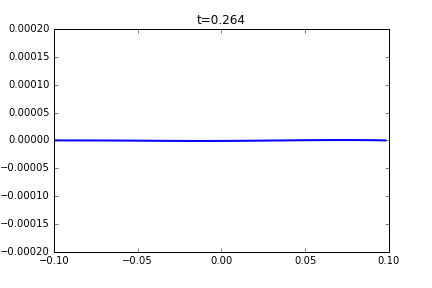
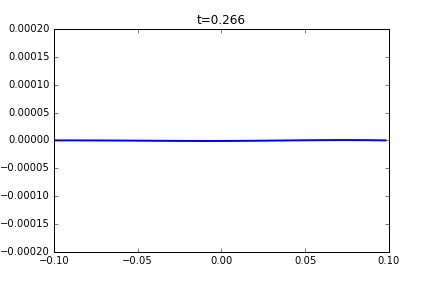
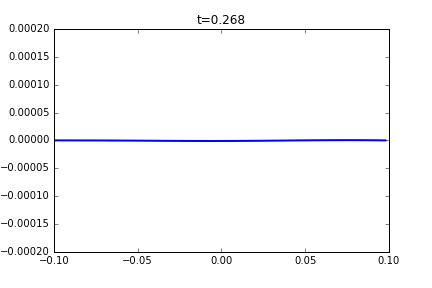
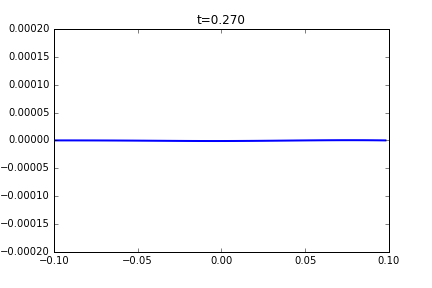
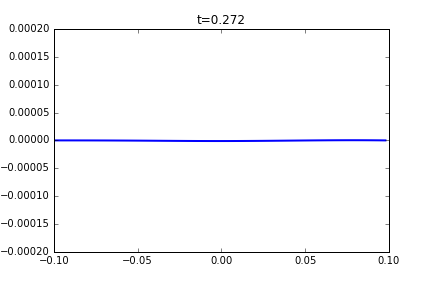
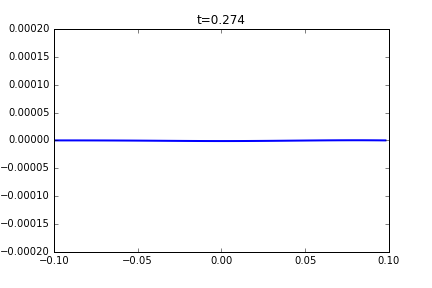
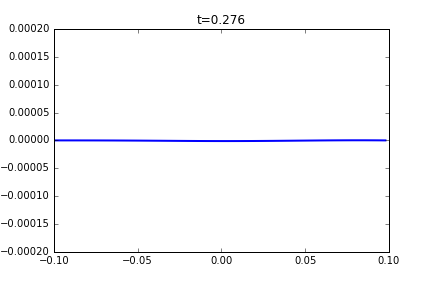
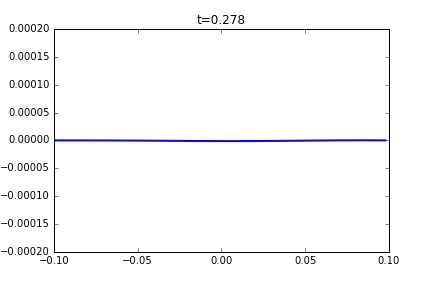
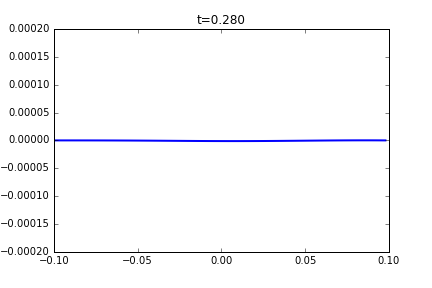
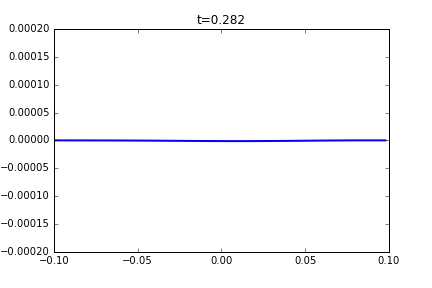
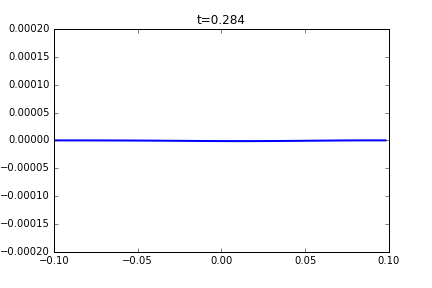
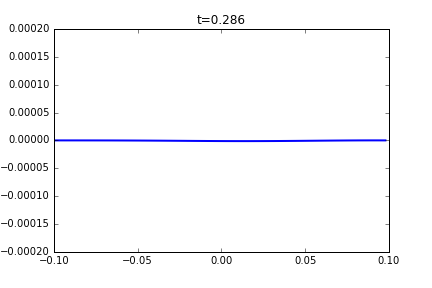
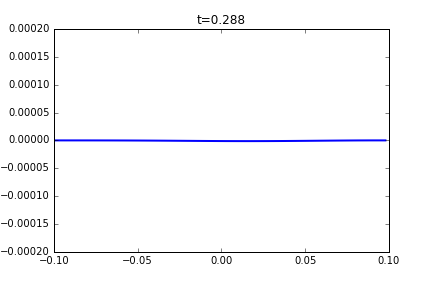
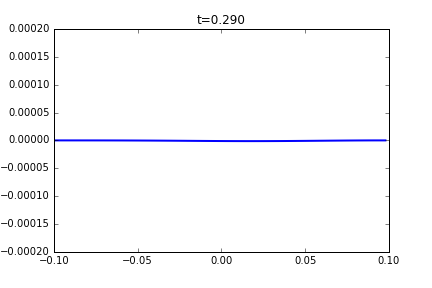
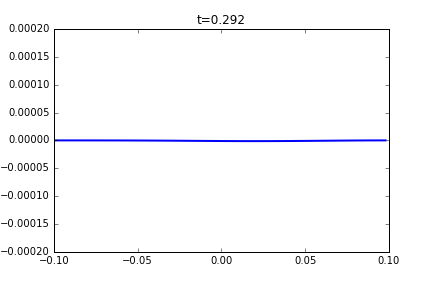
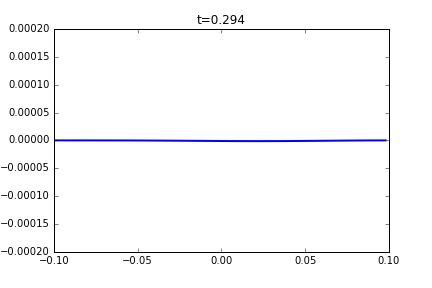
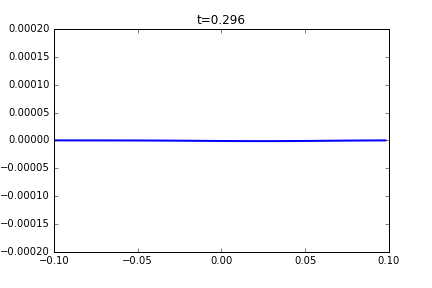
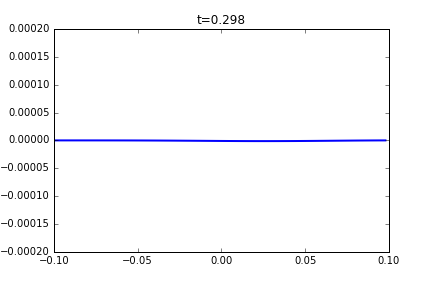
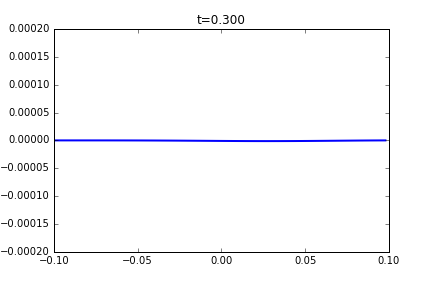
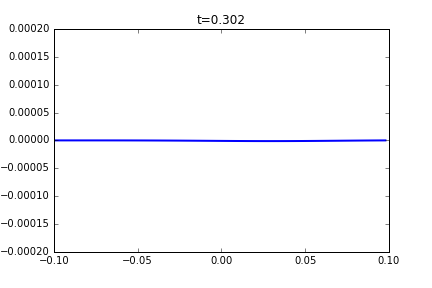

In [16]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(xmin, xmax), ylim=(-2*A, 2*A))
line, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$u$')
title = ax.set_title(r'$t=0.0 s$')


def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, uall[:,i])
    title.set_text('t=%.3f'%(tall[i]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=uall.shape[-1], interval=300)